In [31]:
# !git clone https://github.com/PeterLiu1034/Udacity_simulator_Track_for_assignment.git # 

In [32]:
ls Udacity_simulator_Track_for_assignment

 驱动器 C 中的卷是 Windows-SSD
 卷的序列号是 7ACC-FE5B

 C:\Users\lenovo\Documents\0_vip_files_without_cloud\Udacity_simulator_Track_for_assignment 的目录

07/11/2021  17:39    <DIR>          .
07/11/2021  17:39    <DIR>          ..
07/11/2021  15:49         2,739,588 driving_log.csv
07/11/2021  15:49    <DIR>          IMG
07/11/2021  17:39                90 README.md
               2 个文件      2,739,678 字节
               3 个目录 55,468,261,376 可用字节


In [33]:
# 导入所需库
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # 用于读取图片
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Conv2D
from sklearn.utils import shuffle # 元素随机排序
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa # 用于数据增广
import cv2
import pandas as pd
import ntpath
import random

In [34]:
# 整理查看表格中数据，增加表头
datadir = 'Udacity_simulator_Track_for_assignment'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', 40) # 列宽40
data.head()

center  \
0  C:\Users\lenovo\Documents\0_vip_file...   
1  C:\Users\lenovo\Documents\0_vip_file...   
2  C:\Users\lenovo\Documents\0_vip_file...   
3  C:\Users\lenovo\Documents\0_vip_file...   
4  C:\Users\lenovo\Documents\0_vip_file...   

                                      left  \
0   C:\Users\lenovo\Documents\0_vip_fil...   
1   C:\Users\lenovo\Documents\0_vip_fil...   
2   C:\Users\lenovo\Documents\0_vip_fil...   
3   C:\Users\lenovo\Documents\0_vip_fil...   
4   C:\Users\lenovo\Documents\0_vip_fil...   

                                     right  steering  throttle  reverse  \
0   C:\Users\lenovo\Documents\0_vip_fil...       0.0       0.0      0.0   
1   C:\Users\lenovo\Documents\0_vip_fil...       0.0       0.0      0.0   
2   C:\Users\lenovo\Documents\0_vip_fil...       0.0       0.0      0.0   
3   C:\Users\lenovo\Documents\0_vip_fil...       0.0       0.0      0.0   
4   C:\Users\lenovo\Documents\0_vip_fil...       0.0       0.0      0.0   

      speed  
0  0.000068  
1  0.000069  
2  0.000071  
3  0.000069  
4  0.000069

In [35]:
# 对路径进行切片
def path_leaf(path):
  head, tail = ntpath.split(path) # 通过指定分隔符对字符串进行切片
  return tail
data['center'] = data['center'].apply(path_leaf) #保留图片文件名中center开始后面部分
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center                              left  \
0  center_2021_11_07_15_23_32_419.jpg  left_2021_11_07_15_23_32_419.jpg   
1  center_2021_11_07_15_23_32_522.jpg  left_2021_11_07_15_23_32_522.jpg   
2  center_2021_11_07_15_23_32_622.jpg  left_2021_11_07_15_23_32_622.jpg   
3  center_2021_11_07_15_23_32_722.jpg  left_2021_11_07_15_23_32_722.jpg   
4  center_2021_11_07_15_23_32_824.jpg  left_2021_11_07_15_23_32_824.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2021_11_07_15_23_32_419.jpg       0.0       0.0      0.0  0.000068  
1  right_2021_11_07_15_23_32_522.jpg       0.0       0.0      0.0  0.000069  
2  right_2021_11_07_15_23_32_622.jpg       0.0       0.0      0.0  0.000071  
3  right_2021_11_07_15_23_32_722.jpg       0.0       0.0      0.0  0.000069  
4  right_2021_11_07_15_23_32_824.jpg       0.0       0.0      0.0  0.000069

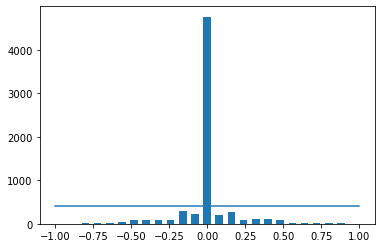

In [36]:
# 柱状图展示方向盘数据，0为直行，其中400是暂定的每个区间最大样本数，避免直行样本过多
num_bins = 25 # num_bins（bins）：统计的区间个数
samples_per_bin = 400 # 每个区间最大样本数，避免直行样本数量过大，如果最后训练的模型不爱走直线，可以再增大这个数
hist, bins = np.histogram(data['steering'], num_bins) # hist：直方图各列高度；bins（bin_edges）=(length(hist)+1)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05) # 根据上述参数画柱状图
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
# plot的前面两个参数是横坐标，后两个是纵坐标

total data: 6657
removed: 4359
remaining: 2298


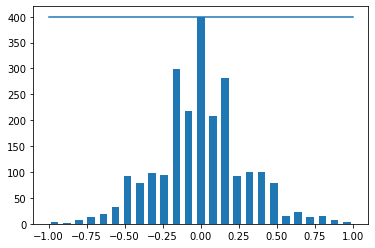

In [37]:
# 展示现有数据（保留少部分直行0样本后的数据）
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]: #比如0.97、0.95属于同一个bin
      list_.append(i)
  list_ = shuffle(list_) # shuffle所有元素随机排序，避免删除的直行数据过于集中，造成汽车在某些情况不会走直路
  list_ = list_[samples_per_bin:] #第400之后归于list_,方便删除
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True) # Drop函数删除Dataframe指定行列
print('remaining:', len(data))
 
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [38]:
# 显示数据的构成方便下一步读取整理
print(data.iloc[1]) # iloc用于索引或切片; 下方center、left、right是指三部摄像机位置，不是指汽车方向

center      center_2021_11_07_15_23_34_749.jpg
left          left_2021_11_07_15_23_34_749.jpg
right        right_2021_11_07_15_23_34_749.jpg
steering                                   0.0
throttle                                   1.0
reverse                                    0.0
speed                                 15.46615
Name: 22, dtype: object


In [39]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    # center image append
    image_path.append(os.path.join(datadir, center.strip()))  # Udacity_simulator_Track01/IMG/center_2021....
    # os.path.join()函数用于路径拼接文件路径
    # strip() 方法用于移除字符串头尾指定的字符
    
    # steering angle append
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path) # 数据格式由list调整为array
  steerings = np.asarray(steering)
  return image_paths, steerings
 
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [40]:
# 将数据集分成训练集和测试集，比例8比2
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 5515
Valid Samples: 1379


Text(0.5, 1.0, 'Validation set')

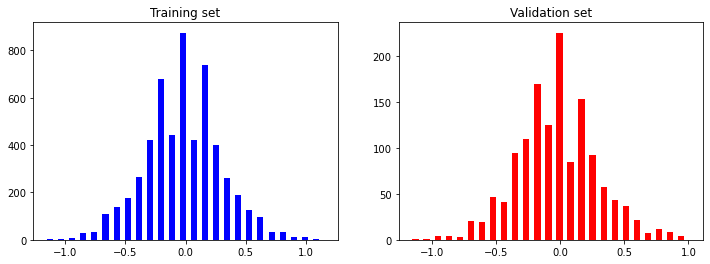

In [41]:
# 图片显示训练集和测试集
fig, axes = plt.subplots(1, 2, figsize=(12, 4)) # plt.subplot()函数用于直接指定划分方式和位置进行绘图
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

Text(0.5, 1.0, 'Zoomed Image')

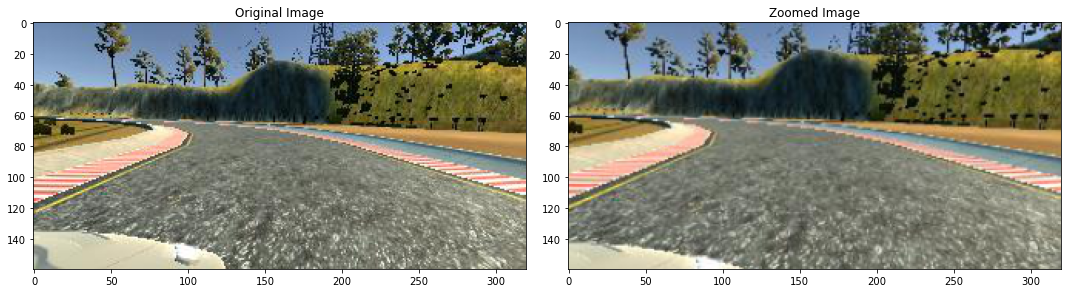

In [42]:
# 放大图片
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3)) # 放大图片，同时减少周围景观和车辆轮廓这些噪音
  image = zoom.augment_image(image)
  return image

image = image_paths[random.randint(0, 1000)] # 随机抽取一张幸运照片
original_image = mpimg.imread(image)  # 此前存储的是image path，所以这里要先读取照片
zoomed_image = zoom(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10)) # plt.subplot()函数用于直接指定划分方式和位置进行绘图
fig.tight_layout() # 确保两张照片不重叠
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

Text(0.5, 1.0, 'Panned Image')

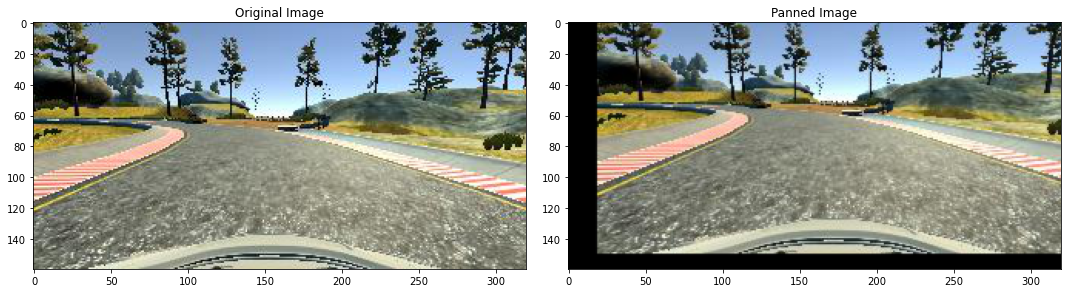

In [43]:
# 平移图片
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)}) # 在x轴和y轴上独立地将图像平移-10到+10％
  image = pan.augment_image(image)
  return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

Text(0.5, 1.0, 'Brightness altered image ')

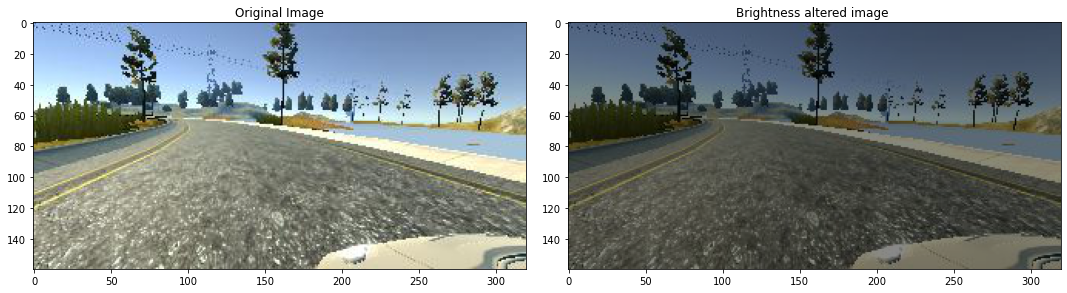

In [44]:
# 图片亮度调节
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2)) # 将给像中图的每个像素点随机乘以0.2到1.2之间的随机值，
    image = brightness.augment_image(image) # 让照片大概率变暗，以适应不同亮度条件
    return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.2558349')

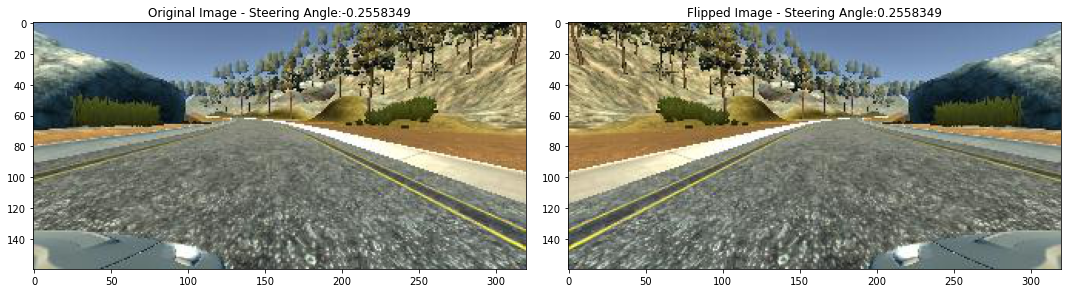

In [45]:
# 水平翻转
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1) # 1为水平镜像照片
    steering_angle = -steering_angle # 记得转向角度也要反转
    return image, steering_angle

random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
 
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [46]:
# 机选一种图像增广技术,这样可以增加样本的多样性，提升机器学习效率
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5: # np.random.rand()可以返回一个或一组服从“0~1”均匀分布的随机样本值，
      image = pan(image)       # 随机样本取值范围是[0,1)，不包括1
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle

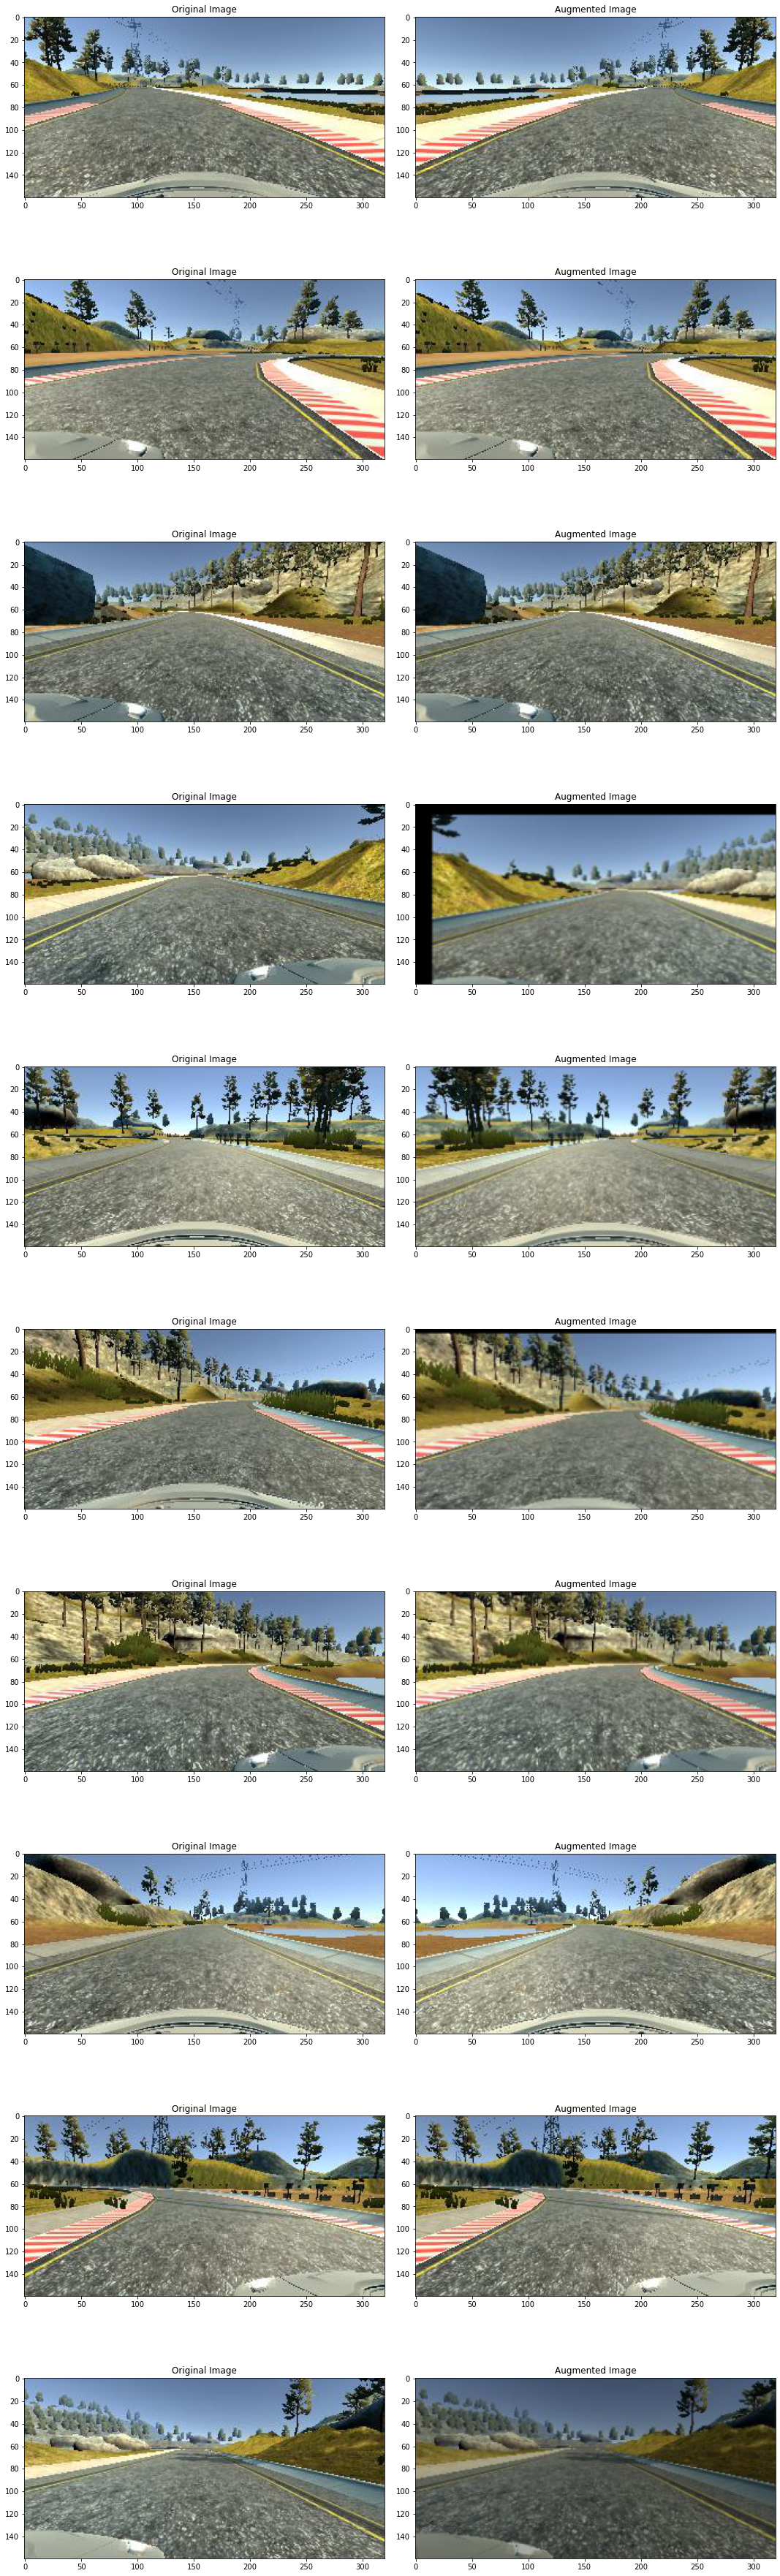

In [47]:
# 搞10组图像增强瞅瞅
ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

Text(0.5, 1.0, 'Preprocessed Image')

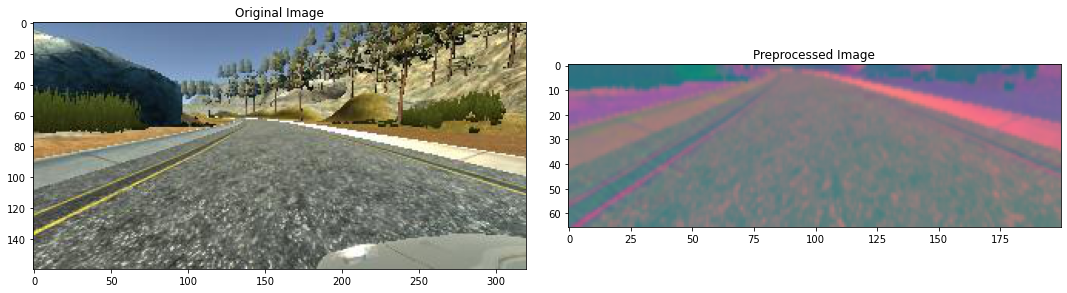

In [48]:
# 图像预处理
def img_preprocess(img):
    img = img[60:135,:,:] # y轴方向只保留60至135，这样大大减少周围景观和车辆轮廓这些噪音
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV) # 图片由RGB格式调整为YUV，方便识别车道线
    img = cv2.GaussianBlur(img,  (3, 3), 0)  # 高斯模糊降噪
    img = cv2.resize(img, (200, 66))  # 降低图片大小，以便降低模型训练时间；同时200*66符合nvidia_model的input要求
    img = img/255 # familiar normalization 标准化，类似于数据的特征缩放，
    return img    #不然同样是图片中的火把，晚上的照片会比白天对神经网络训练模型影响更大

image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image') 

In [49]:
# def一个批量样本生成器，其中batch_size决定样本数量，istraining区分训练集和测试集
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      # keras 使用迭代器来实现大数据的训练, 其简单的思想就是,使用迭代器从文件中去顺序读取数据。
      # 所以自己的训练数据一定要先随机打散。因为我们的迭代器也是每次顺序读取一个batch_size的数据进行训练。
      
      if istraining: # istraining为1时
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index]) # 测试集不需要进行图像增强
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering)) # 转格式为array以用于后面model.fit()

Text(0.5, 1.0, 'Validation Image')

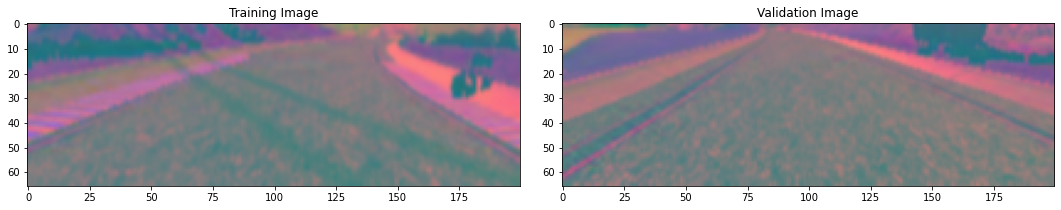

In [50]:
# 对比显示下训练集和测试集处理后的图片
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1)) # 利用next模拟keras迭代器的效果 
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image') # 可见训练集经过图片增广augment后图像更加模糊平滑
 
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image') # 测试集的图像只经过了预处理preprocessing

In [52]:
# 第一轮炼丹

In [53]:
def nvidia_model():
    model = Sequential()

    model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='relu'))
    model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='relu'))
    model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='relu'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu')) # 5层卷积层
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation ='relu'))
    model.add(Dense(1))

    optimizer= Adam(lr=1e-3) # 0.001，低学习率有助于提升准确度
    model.compile(loss='mse', optimizer=optimizer) # 回归类型的损失函数用mse

    return model

model = nvidia_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

In [54]:
# 数据量很大，那么是不可能通过model.fit()将所有数据载入内存的，必将导致内存泄漏，
# 这时候我们可以用fit_generator函数来进行训练
# 下面100为batch_size,100个图片per step
# 每个epoch有300steps，也就是30000张照片，这个数较大，所以epoch只设置10轮
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Epoch 1/10
300/300 [==============================] - 168s 559ms/step - loss: 0.0998 - val_loss: 0.0975
Epoch 2/10
300/300 [==============================] - 166s 553ms/step - loss: 0.0985 - val_loss: 0.0968
Epoch 3/10
300/300 [==============================] - 178s 595ms/step - loss: 0.0991 - val_loss: 0.0960
Epoch 4/10
300/300 [==============================] - 172s 574ms/step - loss: 0.0977 - val_loss: 0.0966
Epoch 5/10
300/300 [==============================] - 164s 547ms/step - loss: 0.0983 - val_loss: 0.0965
Epoch 6/10
300/300 [==============================] - 171s 569ms/step - loss: 0.0990 - val_loss: 0.0967
Epoch 7/10
300/300 [==============================] - 163s 543ms/step - loss: 0.0994 - val_loss: 0.0960
Epoch 8/10
300/300 [==============================] - 172s 573ms/step - loss: 0.0975 - val_loss: 0.0962
Epoch 9/10
300/300 [==============================] - 222s 740ms/step - loss: 0.0981 - val_loss: 0.0963
Epoch 10/10
300/300 [==============================] - 236s 786m

Text(0.5, 0, 'Epoch')

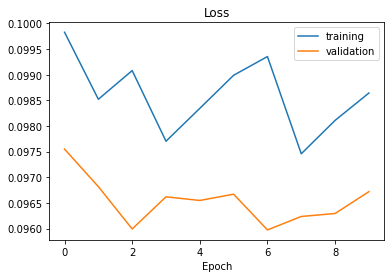

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [56]:
# 第二轮炼丹

In [57]:
def nvidia_model():
    model = Sequential()

    model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='elu'))

    model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
    model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='elu')) # 5层卷积层
    model.add(Dropout(0.5))


    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dropout(0.5))


    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation ='elu'))
    model.add(Dense(1))


    optimizer= Adam(lr=1e-3) # 0.001，低学习率有助于提升准确度
    model.compile(loss='mse', optimizer=optimizer) # 回归类型的损失函数用mse

    return model

model = nvidia_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)             

In [58]:
# 数据量很大，那么是不可能通过model.fit()将所有数据载入内存的，必将导致内存泄漏，
# 这时候我们可以用fit_generator函数来进行训练
# 下面100为batch_size,100个图片per step
# 每个epoch有300steps，也就是30000张照片，这个数较大，所以epoch只设置10轮
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Epoch 1/10
300/300 [==============================] - 184s 613ms/step - loss: 0.0974 - val_loss: 0.0487
Epoch 2/10
300/300 [==============================] - 184s 614ms/step - loss: 0.0660 - val_loss: 0.0447
Epoch 3/10
300/300 [==============================] - 177s 591ms/step - loss: 0.0619 - val_loss: 0.0412
Epoch 4/10
300/300 [==============================] - 180s 599ms/step - loss: 0.0595 - val_loss: 0.0384
Epoch 5/10
300/300 [==============================] - 196s 652ms/step - loss: 0.0565 - val_loss: 0.0403
Epoch 6/10
300/300 [==============================] - 208s 694ms/step - loss: 0.0543 - val_loss: 0.0388
Epoch 7/10
300/300 [==============================] - 215s 716ms/step - loss: 0.0528 - val_loss: 0.0365
Epoch 8/10
300/300 [==============================] - 204s 679ms/step - loss: 0.0511 - val_loss: 0.0349
Epoch 9/10
300/300 [==============================] - 221s 737ms/step - loss: 0.0495 - val_loss: 0.0352
Epoch 10/10
300/300 [==============================] - 176s 588m

Text(0.5, 0, 'Epoch')

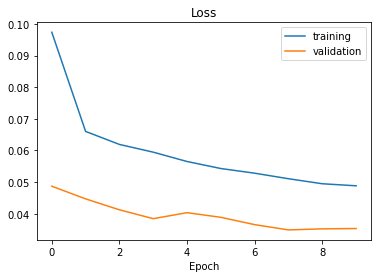

In [59]:
# 图片显示loss（由于完全相同，二、三轮炼丹不再重返展示本段代码）
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [60]:
# 第三轮炼丹

In [61]:
def nvidia_model():
    model = Sequential()

    model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='elu'))

    model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
    model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='elu')) # 5层卷积层
    # model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    # model.add(Dropout(0.5))

    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation ='elu'))
    model.add(Dense(1))

    optimizer= Adam(lr=1e-3) # 0.001，低学习率有助于提升准确度；如果最后的loss折线图振荡明显，可以降低为0.0001试试
    model.compile(loss='mse', optimizer=optimizer) # 回归类型的损失函数用mse

    return model

model = nvidia_model()
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)              

In [62]:
# 数据量很大，那么是不可能通过model.fit()将所有数据载入内存的，必将导致内存泄漏，
# 这时候我们可以用fit_generator函数来进行训练
# 下面100为batch_size,100个图片per step
# 每个epoch有300steps，也就是30000张照片，这个数较大，所以epoch只设置10轮
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Epoch 1/10
300/300 [==============================] - 172s 573ms/step - loss: 0.1284 - val_loss: 0.1000
Epoch 2/10
300/300 [==============================] - 170s 565ms/step - loss: 0.0741 - val_loss: 0.0649
Epoch 3/10
300/300 [==============================] - 170s 566ms/step - loss: 0.0646 - val_loss: 0.0485
Epoch 4/10
300/300 [==============================] - 173s 575ms/step - loss: 0.0577 - val_loss: 0.0413
Epoch 5/10
300/300 [==============================] - 184s 612ms/step - loss: 0.0515 - val_loss: 0.0407
Epoch 6/10
300/300 [==============================] - 178s 594ms/step - loss: 0.0476 - val_loss: 0.0401
Epoch 7/10
300/300 [==============================] - 167s 557ms/step - loss: 0.0448 - val_loss: 0.0358
Epoch 8/10
300/300 [==============================] - 167s 557ms/step - loss: 0.0428 - val_loss: 0.0365
Epoch 9/10
300/300 [==============================] - 164s 547ms/step - loss: 0.0418 - val_loss: 0.0370
Epoch 10/10
300/300 [==============================] - 175s 584m

Text(0.5, 0, 'Epoch')

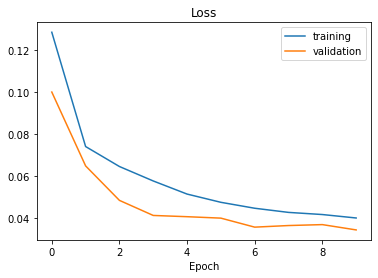

In [63]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [64]:
# 保存模型
model.save('model_assignment_4.h5') 

In [ ]:
# 用于google.colab下载，jupyter中上一步会直接保存在本地
# from google.colab import files
# files.download('model.h5')